## Proposal:

### *Environment: (dependent on the user)*

**States:** two dimensions: **tilt** and **closeness** to the screen. 
- Along the **tilt** dimension, we have discretized the head roll angle to three possible values: *left*, *normal* and *right*. 
- Along the **closeness** dimension (*y* coordinate from the tablet) we can either have a *normal* distance or *too close* (below a certain threshold)

This forms a 2x3 state space, where the only valid posture that does not trigger the intervention is (normal, normal). The thing is that then, $p_{EC}$ and $p_{EA}$ should be incorporated in the transition matrix as the probability of getting from some state to the *normal* state (the probability of the intervention actually working, from each state and for each action/intervention). 

<img src="states.png" alt="state space" width="400"/>


**Actions:** **EC**, **EA**, **DO NOTHING**.
- Instead of $p_{EC}$ and $p_{EA}$ from k-armed bandit, which denoted the success of the respective strategies, we model them through the transition matrix.
- "Do nothing" should model the agent applying no intervention if the current state is (normal, normal). The transition probabilities for this action are decaying as the time passes, modeling the fatigue of the user.

The question is: How to define iterations then? Is that the possibility of going from a normal state to other states? We need an action of doing nothing, and a high probability of going from the normal state to others,... while also that probability should get higher as the experiment goes on...
The problem also is the fact that a person can move from state to state regardless of the fact that our agent has taken an action or not... That is especially the case if the state is normal - our agent might learn to do nothing, but how do we impose that it actually goes to some other state, is it by transition matrix and a possibility of it going to some other state even though from neutal doing nothing should take you to a neutral state?

**Reward system:**

Rewards depend on the current state, action taken, and the next state. The logic was as follows:
- As for the intervention actions, EC and EA, if the current state is in bad posture (states 0,1,2,3,5), we define rewards w.r.t the next state we end up in as: next state has both state dimensions as non-normal, then the reward is -1; if one dimension is normal, the reward is -0.5 and if we end up in (normal,normal) state (state 4), the reward is 1. If the current state is normal posture (state 4) then if we end up in a non-normal state the reward is -1 (we wanted to penalize the agent for leaving the normal state) and if we end up in a normal state again, then the reward is 0 (the agent applied a corrective action without necessity, it is by chance that we stayed in the normal state)
- For the action DO NOTHING and starting from non-normal states, we penalize with -1 ending up in any non-normal state (the agent should have applied the intervention), and if we end up in the normal state, we assign a reward of 0 (it is the environment's stochasticity that lead us to normality, not the agent). When starting from a normal state, we reward the agent with 1 if he stays there (indeed he needed not to do anything), and with 0 if he ends up in a bad posture state (to mimic the movement of a real user; it's not the agent' fault)

**Non-episodic learning:** We start from Q values set to zero each time, this means that we don't learn anything from experiment to experiment

### Additional remarks:

*Transition matrix*: Since we added DO NOTHING action, which still has probabilities of ending up in any state of the environment, it should model the stochasticity such as user moving randomly. We set the diagonal of the transition matrix to high values at the beginning (the user will probably not move from the current state if the agent does nothing), but as the experiment progresses, these probabilities get lower and lower (transition_decay) modeling e.g. the user's fatigue.

*Non-episodic learning*: Since in paper they say: "We cannot draw a conclusive conclusion about whether children's understanding of the intervention strategy influences the effectiveness of the system. Further experiments are still required.", maybe for now we do not simulate a single user doing the experiment multiple times. If we end up deciding to do so, then we have to create an agent for every user, which will learn from experiment to experiment, that won't be non-episodic learning anymore... 

*User class*: Maybe to make a user class that has its own transition matrix that is user-dependent. Also, if we decide to do an episodic learning (i.e. the user has already taken the experiment in the past), we should save the Q-values after each experiment (episode) and start from these when running a new one for this user.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' # Keep using keras-2 (tf-keras) rather than keras-3 (keras).

import numpy as np
import tensorflow as tf
import tf_agents.environments as tf_env
import tf_agents.specs as tf_specs
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import time_step as ts
from utils.mdp_solver import MDPsolver
from abc import abstractmethod

In [3]:
class WUREnvironment():
    # Encode action:
    # EC = 0
    # EA = 1
    # DO NOTHING = 2

    def __init__(self, transition_model):
        # Defining the number of states
        self._num_states = 6
        # Defining the number of actions
        self._num_actions = 3
        # Discount factor
        self._gamma = 0.99
        # Decaying factor for DO NOTHING action in transition matrix
        self._transition_decay = 0.99
        # User specifications - transition matrix
        self._T = transition_model # shape = (num_actions, num_states, num_states); Dependent on the user -> given externally
        
        # Reward system matrix (num_actions, num_states, num_states)
        self.reward = np.array([
            [
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-1,-1,-1,0,-1],
                [-1,-0.5,-1,-0.5,1,-0.5]
            ], # EC
            [
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-0.5,-1,-0.5,1,-0.5],
                [-1,-1,-1,-1,0,-1],
                [-1,-0.5,-1,-0.5,1,-0.5]
            ], # EA
            [
                [-1,-1,-1,-1,0,-1],
                [-1,-1,-1,-1,0,-1],
                [-1,-1,-1,-1,0,-1],
                [-1,-1,-1,-1,0,-1],
                [0,0,0,0,1,0],
                [-1,-1,-1,-1,0,-1]
            ] # DO_NOTHING
        ]) 
        
        self.current_state = 4 # the default (normal, normal) state
        self._step_count = 0
        self._total_reward = 0.0

    def _decay_transitions(self):
        for i in range(self._num_states):
            decay_update = self._T[2][i, i] * self._transition_decay
            decay_update = decay_update if decay_update > 0.6 else 0.6
            self._T[2][i, i] = decay_update
            self._T[2][i] /= np.sum(self._T[2][i])

    def _step(self, action):
        """
        Inputs:
        action - chosen action of the step with eps-greedy exploration
        alpha - a.k.a. learning_rate
        """
        # To which state next does the action take us?
        new_state = np.random.choice(np.arange(self._num_states), p=self._T[action][self.current_state])
        reward = self.reward[action, self.current_state, new_state]
        
        prev_state = self.current_state
        self.current_state = new_state

        self._step_count += 1
        self._total_reward += reward

        self._decay_transitions()
        return reward, prev_state 

In [4]:
class EpsGreedyAgent:
    def __init__(self, env: WUREnvironment, explore_rate = 1.0):
        self.num_actions = env._num_actions
        self.num_states = env._num_states
        self.env = env

         # Initialization of Q and N
        self.Q = np.zeros(shape=(self.num_states, self.num_actions), dtype=float)
        self.N = np.zeros((self.num_states, self.num_actions), dtype=int)

        self.step_counts = 0
        self.explore = explore_rate  
        self.reward_history = []

    def select_action(self, state):
        # Should be selected on the basis of epsilon greedy from the current state
        explore = np.random.binomial(2, p=self.explore)
        if explore:
            # Exploration: With probability epsilon take a random action, an index of an action
            a = np.random.choice(np.arange(self.num_actions))
        else:
            # Exploitation: With probability 1 - epsilon take one of the optimal actions for the current state
            a = np.argmax(self.Q[state, :])
        return a

    @abstractmethod
    def update_estimates(self, action, reward, prev_state):
        pass
    
    def get_current_average_reward(self):
        return np.mean(self.reward_history)
    
    def get_cumulative_reward(self):
        return np.sum(self.reward_history)

In [5]:
class QEpsGreedyAgent(EpsGreedyAgent):
    def update_estimates(self, action, reward, prev_state):
        
        """
        Updates the values of action counts, step counts, reward history etc.

        Inputs:
        action - action taken in the current step
        reward - reward collected while taking the step when interacting with the environment
        alpha - 
        """
        # Interaction with the environment - collecting reward 
        self.reward_history.append(reward)

        self.N[prev_state, action] += 1
        alpha = 0.5 / (self.N[prev_state, action] + 1) ** 0.75

        # Update Q according to the algorithm
        self.Q[prev_state, action] = \
            (1 - alpha) * self.Q[prev_state, action] + alpha * (reward + self.env._gamma*np.max(self.Q[self.env.current_state, :]))        
        
        self.step_counts += 1
        return None

In [6]:
class SARSAEpsGreedyAgent(EpsGreedyAgent):
    def update_estimates(self, action, reward, prev_state):
        """
        Updates the values of action counts, step counts, reward history etc.

        Inputs:
        action - action taken in the current step
        reward - reward collected while taking the step when interacting with the environment
        alpha - 
        """
        # Interaction with the environment - collecting reward 
        self.reward_history.append(reward)

        self.N[prev_state, action] += 1
        alpha = 0.5 / (self.N[prev_state, action] + 1) ** 0.75

        # Sampling a new action
        new_action = self.select_action(self.env.current_state)
        # Update Q according to the algorithm
        self.Q[prev_state, action] = (1 - alpha) * self.Q[prev_state, action] + alpha * (reward + self.env._gamma*self.Q[self.env.current_state, new_action])
        
        self.step_counts += 1

        return new_action

In [7]:
def user_simulation(transition_model, algorithm: str, num_iterations = 500, explore_rate = 0.1):
  """
  
  """
  # Create the environment
  env = WUREnvironment(transition_model)
  # Create the epsilon greedy agent
  if algorithm == "Q":
    agent = QEpsGreedyAgent(env, explore_rate)
  elif algorithm == "SARSA":
    agent = SARSAEpsGreedyAgent(env, explore_rate)
  else:
    ValueError(f"Invalid algorithm '{algorithm}' chosen.")

  average_rewards = []
  rmse = []

  if isinstance(agent, QEpsGreedyAgent):
    for _ in range(num_iterations):
      action = agent.select_action(env.current_state)
      reward, prev_state = env._step(action)
      agent.update_estimates(action, reward, prev_state)
      
      # Logs for plotting
      average_rewards.append(agent.get_current_average_reward())
      
  elif isinstance(agent, SARSAEpsGreedyAgent):
    # Training loop
    action = agent.select_action(env.current_state)
    for _ in range(num_iterations):
        reward, prev_state = env._step(action)
        action = agent.update_estimates(action, reward, prev_state)

        # Logs for plotting
        average_rewards.append(agent.get_current_average_reward())

  else:
    raise ValueError(f"Unknown agent type {agent.__class__}.")

  # Evaluate the agent
  if False:
    total_reward = 0.0
    for _ in range(10):  # Test for 10 episodes
        time_step = env.reset()
        while not time_step.is_last():
            action = agent.select_action()
            time_step = env.step(action)
            total_reward += time_step.reward
    print(f'Average Reward of 10 episodes: {total_reward / 10 / 1000}')

  return average_rewards, rmse, agent.reward_history, agent.Q

[[10.86085383 10.62784761  8.36816785]
 [11.13849203 10.57825509  8.68165104]
 [ 9.49306094 11.17186335  8.73679341]
 [11.08951169 10.56557436  8.56492765]
 [10.37880348 10.0505858  11.31753375]
 [11.19099137 10.41691753  8.81230042]]


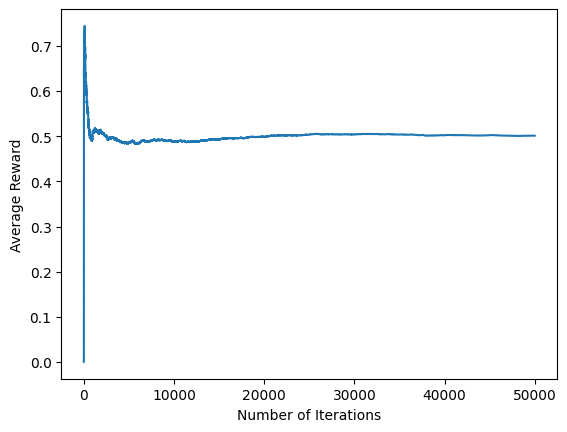

In [8]:
# fix random seed
np.random.seed(0)

# Simulating a user with a transition model
# for EA, for the normal state, we should put high probability that the state would end up in bad posture? to encourage the system to do nothing...
# but what foe EC since it would probably enlarge the text?
transition_matrix = np.array([
    [
        [0.2, 0.025, 0.025, 0.025, 0.7, 0.025],
        [0.025, 0.1, 0.025, 0.025, 0.8, 0.025],
        [0.025, 0.025, 0.2, 0.025, 0.7, 0.025],
        [0.025, 0.025, 0.025, 0.1, 0.8, 0.025],
        [0.02, 0.02, 0.02, 0.02, 0.9, 0.02],
        [0.025, 0.025, 0.025, 0.025, 0.8, 0.1]
    ],
    [
        [0.1, 0.025, 0.025, 0.025, 0.8, 0.025],
        [0.025, 0.1, 0.025, 0.025, 0.8, 0.025],
        [0.025, 0.025, 0.1, 0.025, 0.8, 0.025],
        [0.025, 0.025, 0.025, 0.1, 0.8, 0.025],
        [0.08, 0.08, 0.08, 0.08, 0.6, 0.08],
        [0.025, 0.025, 0.025, 0.025, 0.8, 0.1]
    ],
    [
        [0.9, 0.02, 0.02, 0.02, 0.02, 0.02],
        [0.02, 0.9, 0.02, 0.02, 0.02, 0.02],
        [0.02, 0.02, 0.9, 0.02, 0.02, 0.02],
        [0.02, 0.02, 0.02, 0.9, 0.02, 0.02],
        [0.02, 0.02, 0.02, 0.02, 0.9, 0.02],
        [0.02, 0.02, 0.02, 0.02, 0.02, 0.9],
    ]
])

average_rewards, rmse, reward_history, Q = user_simulation(transition_model=transition_matrix, explore_rate=0.1, num_iterations=50000, algorithm="Q")

import matplotlib.pyplot as plt
plt.plot(average_rewards)
plt.ylabel('Average Reward')
plt.xlabel('Number of Iterations')

print(Q)

[[7.28939874 7.94006645 5.58076805]
 [7.99766448 7.3889521  5.77385599]
 [7.13531452 7.97188399 5.55384752]
 [7.98203659 7.28008287 5.85181988]
 [7.18921716 6.79024446 8.11749964]
 [7.95777595 7.53897665 5.78058963]]


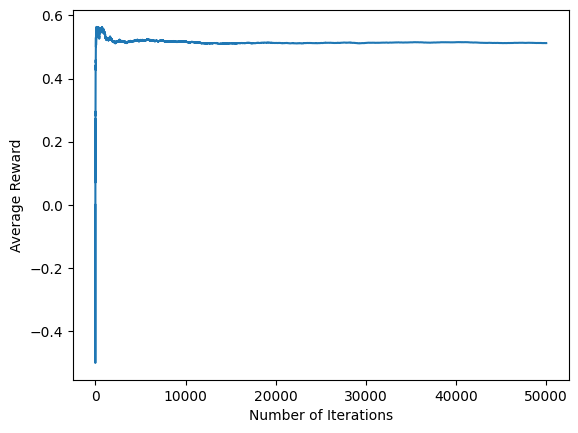

In [9]:
average_rewards, rmse, reward_history, Q = user_simulation(transition_model=transition_matrix, explore_rate=0.1, num_iterations=50000, algorithm="SARSA")

import matplotlib.pyplot as plt
plt.plot(average_rewards)
plt.ylabel('Average Reward')
plt.xlabel('Number of Iterations')

print(Q)